# Case Background & Key Questions	

Flatiron Health Insurance (FHI) is a growing private healthcare insurance provider founded on the premise that using data and analytics can improve the health insurance industry by providing better care and offerings to its patients. Every year, the Center for Disease Control (CDC) conducts surveys to understand the latest demographic, health, and fitness trends. You have been tasked with analyzing the recently published results of his years’ survey and providing your recommendations back to the Chief Analytics Officer and Chief Marketing Officer. You have been assigned the task of taking a first look at the data and beginning to answer several key questions:
											 								
1)  How does health status, represented by average number of days with bad physical health in the past month (PHYSHLTH), differ by state? Also provide an indication of distribution using whatever statistics you find suitable.
 												 								
2)  Digging deeper into the data, what are some factors that impact health (i.e. demographics, behaviors, previous illness, etc.)?	
						 						
To get you started, the IT department formatted the data set into a tab delimited text file for only NY, NJ, and CT (FHI’s primary markets) called `case_studey.csv`. Below you will find a list of steps/questions that you will need to take in your investigation. The first part of the notebook will be focused on cleaning up your data and vidualizing it.  The second part of the data set will be focused on performing statistical tests to make statements with statistical significance.  


In [275]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('dark_background')

import seaborn as sns
sns.set_style('darkgrid')

# pd.read_csv('case_study.csv')

In [276]:
#Load our dataframe account for the index columns
df = pd.read_csv('case_study.csv', index_col=0)

/Users/eric/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (171) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [277]:
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_PASTAE1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
49938,9.0,5.0,5172017,5,17,2017,1200.0,2017000001,2.017000e+09,NaN,...,2.0,2.0,2.0,4.0,2.0,1.0,1.0,NaN,NaN,1.0
49939,9.0,2.0,2142017,2,14,2017,1200.0,2017000002,2.017000e+09,NaN,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,2.0
49940,9.0,1.0,1292017,1,29,2017,1200.0,2017000003,2.017000e+09,NaN,...,3.0,2.0,1.0,3.0,2.0,1.0,1.0,NaN,NaN,2.0
49941,9.0,7.0,9112017,9,11,2017,1200.0,2017000004,2.017000e+09,NaN,...,2.0,2.0,2.0,2.0,2.0,1.0,1.0,NaN,NaN,1.0
49942,9.0,5.0,7182017,7,18,2017,1200.0,2017000005,2.017000e+09,NaN,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,2.0


In [278]:
# Quickly check to see the size of our DF, both rows and columns
df.shape

(34545, 358)

**PHYSHLTH** is the column we are interested in for this analysis, so let's start to investigate the column. Since we have a data cookbook, a.k.a. data dictionary) we want to start there before looking at the code.

## 1. Handle the non-normal values

As you can see from the data dictionary, there are a number of responses that are coded with values that could throw off our descriptive statistics.  Let's clean up by mapping the responses to a more appropriate value, and handling any missing values.  

In [286]:
#your code here
zero_dict = {88:0, 77: np.nan, 99: np.nan}
df['PHYSHLTH'] = df['PHYSHLTH'].replace(zero_dict)

In [287]:
# Set state names
df['_STATE'].replace(9.0, 'CT', inplace=True)
df['_STATE'].replace(34.0, 'NJ', inplace=True)
df['_STATE'].replace(36.0, 'NY', inplace=True)

## 2. Generate the descriptive statistics

Now that our target variable is cleaned up lets calculate the descriptive statistics, generate a graph that quickly shows those statistics, and generate a graph shows the distribution of the data.

In [288]:
df['PHYSHLTH'].describe()

count    33747.000000
mean         4.085341
std          8.513293
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max         30.000000
Name: PHYSHLTH, dtype: float64

[Text(0.5, 0, 'Days in Poor Health'),
 Text(0.5, 1.0, 'Health Over Previous 30 Days:\nInterquantile Range of Participants')]

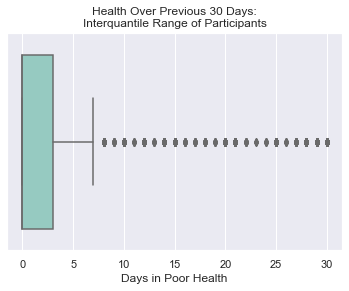

In [289]:
# Plot boxplot of PHYSHLTH values
sns.boxplot(df['PHYSHLTH']).set(
    title='Health Over Previous 30 Days:\nInterquantile Range of Participants',
    xlabel='Days in Poor Health')

[Text(0, 0.5, 'Participants'),
 Text(0.5, 0, 'Days in Poor Health'),
 Text(0.5, 1.0, 'Health Over Previous 30 Days')]

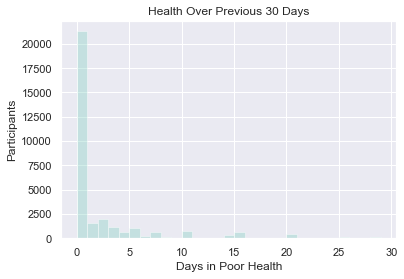

In [290]:
# Graphic the distribution of data
sns.distplot(df['PHYSHLTH'],bins=range(0,30), kde=False).set(
    title='Health Over Previous 30 Days', xlabel='Days in Poor Health',
    ylabel='Participants')

## 3. Generate a graphic that compares the average number of sick days for each state. 

In [291]:
# Code to calculate the average number of sick days by state
avg_sick_days = df.groupby('_STATE')['PHYSHLTH'].mean()
avg_sick_days

_STATE
CT    3.688562
NJ    4.380957
NY    4.148030
Name: PHYSHLTH, dtype: float64

[Text(0, 0.5, 'Days'),
 Text(0.5, 0, 'State'),
 Text(0.5, 1.0, 'Avg. Days in Poor Health By State\nOver Previous 30 Days')]

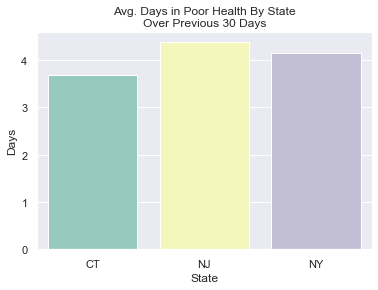

In [292]:
sick_days_plot = (list(avg_sick_days.keys()), list(avg_sick_days[0:3]))
sns.barplot(sick_days_plot[0], sick_days_plot[1]).set(title='Avg. Days in Poor Health By State\nOver Previous 30 Days',
        xlabel='State', ylabel='Days')

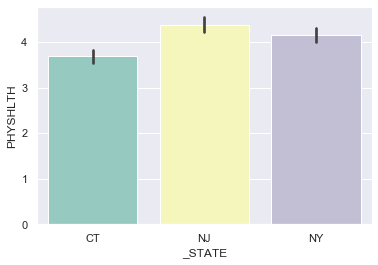

In [293]:
sns.barplot(df['_STATE'], df['PHYSHLTH'], data=df)

In [294]:
df_ct = df.set_index('_STATE').loc['CT']
df_nj = df.set_index('_STATE').loc['NJ']
df_ny = df.set_index('_STATE').loc['NY']

Text(0.5, 0, 'Sick Days')

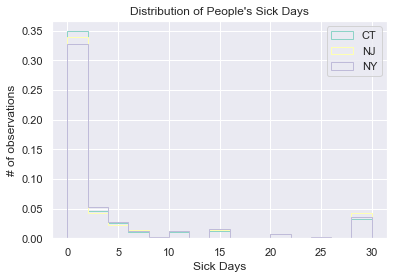

In [297]:
df.groupby('_STATE')['PHYSHLTH'].plot(kind='hist',histtype='step',density=True,bins=15)
plt.legend(labels=['CT','NJ','NY'])
plt.title("Distribution of People's Sick Days")
plt.ylabel('# of observations')
plt.xlabel('Sick Days')
#plt.show()

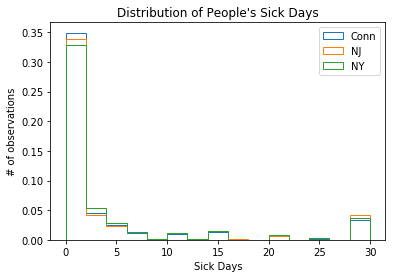

In [19]:
# graphic showing the histogram of data



## 4. Turn the number of sick days into a classification of of chronically sick people.  

Chronically sick people account for a significant proportion of the costs for health insurers. If we can identify what leads people to be chronically sick, we can address them with specific treatments.



In [21]:
# code to create new colum for chronically sick
# solutions branch used chronically sick as >10 days sick
# use np.where, create column with 0,1 values


In [307]:
test = (df['PHYSHLTH'] > 10)
df[test]['PHYSHLTH']

49946     28.0
49955     30.0
49982     15.0
49993     29.0
49995     30.0
          ... 
303735    15.0
303736    30.0
303748    15.0
303751    30.0
303763    15.0
Name: PHYSHLTH, Length: 4326, dtype: float64

In [308]:
chronically_sick = np.where(df['PHYSHLTH'] > 10, 1, 0)
df['CHRONSICK'] = chronically_sick

In [309]:
df['CHRONSICK'].describe()

count    34545.000000
mean         0.125228
std          0.330982
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: CHRONSICK, dtype: float64

## 5. Create a graphic that compares the percentage of people labeled as 'sick' in each state. 

In [310]:
df['CHRONSICK']

49938     0
49939     0
49940     0
49941     0
49942     0
         ..
303774    0
303775    0
303776    0
303777    0
303778    0
Name: CHRONSICK, Length: 34545, dtype: int64

In [23]:
# code to calculate averages per state


_STATE
9.0     0.103428
34.0    0.127335
36.0    0.115948
Name: CHRONIC, dtype: float64

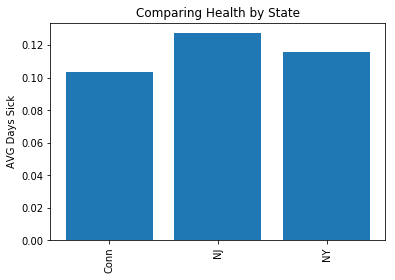

In [24]:
# create graphic to compare chronically sick by state


## 6. Independent Variables (categorical)

Does smoking affect the number of days people feel physically ill? 
Let's take the column `SMOKDAY2` and start to prepare it so that we can see how it is possibly correlated to `PHYSHLTH`. When cleaning this data you will find that many respondents were not asked that question. read the codebook to understand why, and use that information when cleaning up your data. I.E, you will need to process two columns in order to create a new column of smokers.

1. Clean up the values.
2. Calculate the descriptive statistics of the variable.
3. Generate a histogram for the variable.
4. Generate graphics that show how the responses to this variable might differ by state.
5. Generate a graphic that compares the physical health of the different groups of 'smokers'.

In [45]:
# your code here

13468

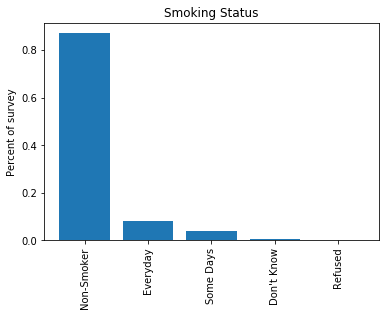

In [52]:
# code to graph those proportion of differen smoking groups using matplotlib


In [54]:
# your code here

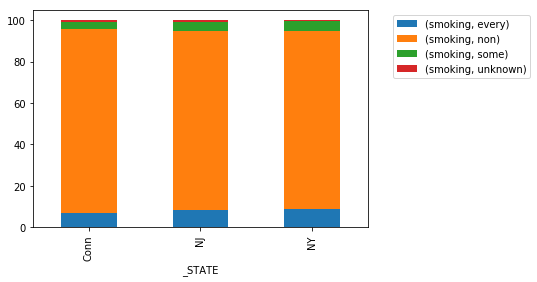

In [63]:
#graph showing the breakdown of smokers per state

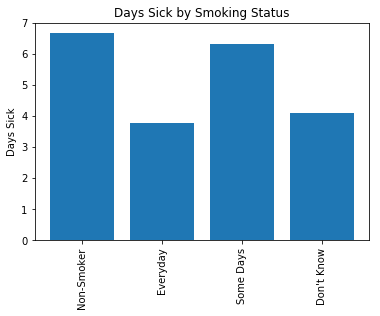

In [65]:
# code to graph these averages sick days for each category of smoking status

## 7. Independent Variables (continuous):

Does the amount of days a person drinks affect the number of days they feel physically ill?
To investigate this, let's look at a continuous variable (ALCDAY5) and see how that might impact a person's health. 

1. Clean up the values.
2. Calculate the descriptive statistics of the variable.
3. Generate a histogram for the variable.
4. Generate graphics that show how the responses to this variable might differ by state.
5. Calculate the correlation coefficient between `PHYSHLTH` and `ALCDAY5`.
5. Generate a graphic that shows the possible relationship between `PHYSHLTH` and `ALCDAY5`.

In [66]:
# code here to clean up the ALCDAY5 responses


In [73]:
#descriptive statistics of cleaned data

count    31532.000000
mean         5.504455
std          8.450005
min          0.000000
25%          0.000000
50%          2.000000
75%          7.000000
max         30.416680
Name: alcohol, dtype: float64

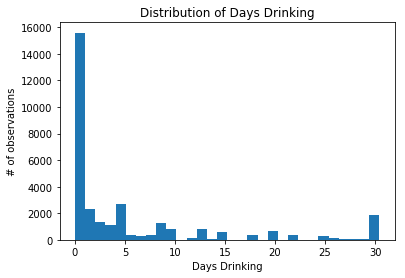

In [75]:
# graphic showing the histogram of data


In [76]:
# code to calculate averages per state


_STATE
9.0     6.208564
34.0    5.068090
36.0    5.309619
Name: alcohol, dtype: float64

In [83]:
# Code to calculate correlation of between number of dirnks of number of days physically ill

PHYSHLTH    1.000000
alcohol    -0.091016
Name: PHYSHLTH, dtype: float64

## 8. Statistical Inference


- Create a 95% confidence interval for the population mean of physically ill days.

-  Create a 95% confidence interval for the true proportion of chronically sick people.

## 9. Hypothesis Tests 

**For the follwing questions that require hypothesis tests, you must complete the following:**

*1. Write down the null and alternative hypothesis you are testing.* 

*2. Select the appropriate test and calculate the test statistic and P-values.*

*3. Determine the critical value for the 95% confidence interval.*

*4. Evaluate the test statistic agains the critical value.*

*5. Determine if you reject or fail to reject the null hypothesis and write a sentence explaining the results of your hypothesis test.*  

### The following questions are regarding the `PHYSHLTH` variable. 
- What is the probability of getting this sample mean for days physically ill, if the population mean is 4?
- Is there a statistically significant difference between men and women in the number of days a person feels phsyically ill?
- Perform a statistical test to determine if there statistically significant difference is physical health of people from the three states. 


### The following questions are regarding the  `CHRONIC` variable.
- What is the probability of drawing this sample proportion if chronically true population proportion is 0.10?
- Is there a statistically significant difference in the percentage of men and women who are chronically sick?
- Perform a statistical test to determine if there statistically significant difference is physical health of people from the three states.

# 10. Independent Investigation

Now that you have invesitgated physical health and chronic sickness and their relationships with states and gender, you will conduct a similar investigation with variables of your choosing. 

Select a continuous dependent varaible and a binary dependent variable that you would like to investigate. Then select a categorical independent variable with at least 3 groups and for which you will test to see if the response to the independent variable affects outcomes of the dependent variable.

For your continuous dependent variable perform the following:
  - Determine the sample mean and sample standard deviation
  - Create a confidence interval for a population mean.
  - Perform a two-sample test of means for gender.
  - Perform a one-way ANOVA using your categorical independent variable.

Select/create a binary variable from the survey questions as you dependent variable and perform the following:
  - Create a confidence interval for a population proportion.
  - Perform a two proportions z-test using gender.
  - Perform a Chi-Square test using your categorical independent variable.